In [1]:
%matplotlib inline

In [4]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [6]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000322,0.043957
2,12/04/1958,317.69,14,0.000643,0.047869
3,19/04/1958,317.58,21,0.000965,0.046737
4,26/04/1958,316.48,28,0.001286,0.035413


In [7]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

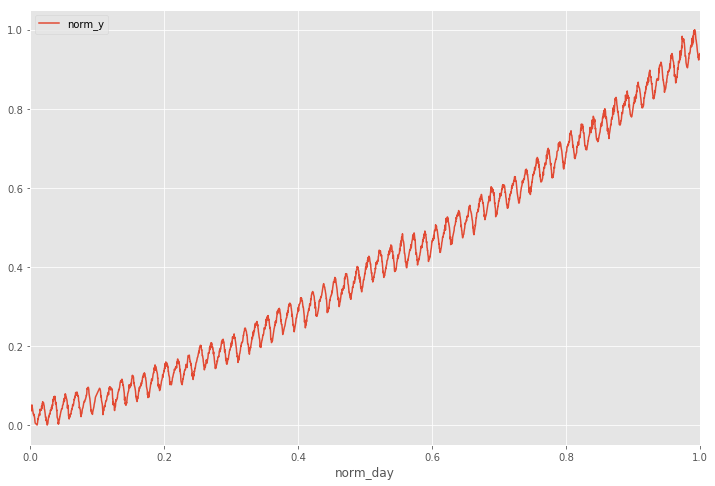

In [8]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

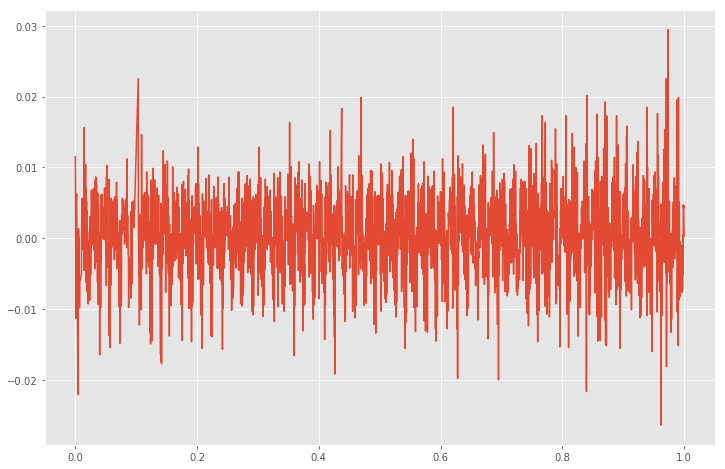

In [9]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
plt.figure(figsize=(12, 8))
plt.plot(mauna_loa['norm_day'][1:], y_diffs)


In [10]:
TRAIN_SIZE = 1040
train = mauna_loa[:TRAIN_SIZE]
test = mauna_loa[TRAIN_SIZE:]

# TEST_SIZE = 52 * 8
# train = mauna_loa[:-TEST_SIZE]
# test = mauna_loa[-TEST_SIZE:]

## Start with a very naive Stan model 

In [11]:
local_linear_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days 
}

parameters {
    real alpha;    // linear regression intercept
    real beta;     // linear regression slope
    real<lower=0> sigma_lr; // linear regression slope
    real<lower=0, upper=1> rho;      // local trend learning rate

    real delta[N];               // slope at time t    
    real<lower=0> sigma_mu;      // standard deviation of the observation noise 
    real<lower=0> sigma_delta;   // standard deviation of the observation noise 
    
    // real mu;
    // real<lower=0> tau;
    
}
/*
transformed parameters {
    
    
    for (j in 1:J)
    theta[j] = mu + tau * eta[j];
}
*/

model {
    alpha ~ normal(0, 0.1);
    beta ~ normal(0, 0.1);
    sigma_lr ~ gamma(1, 0.1);
    rho ~ normal(0.1, 0.03);
    
    y ~ normal(alpha + t * beta, sigma_lr);

    sigma_delta ~ gamma(1, 0.1);
    sigma_mu ~ gamma(1, 0.1);

    delta[1] ~ normal(y[1], sigma_delta);
    y[1] ~ normal(delta[1], sigma_mu);
    
    for (i in 2:N) {
        delta[i] ~ normal(beta + rho * (delta[i - 1] - beta), sigma_delta);
        y[i] ~ normal(y[i - 1] + delta[i], sigma_mu);
    }
}

generated quantities {
  real delta_future[N_future];
  real y_future[N_future];
  
  delta_future[1] = normal_rng(delta[N], sigma_delta);
  y_future[1] = normal_rng(delta_future[1], sigma_mu);
  
  for(i in 2:N_future) {
    delta_future[i] = normal_rng(beta + rho * (delta_future[i - 1] - beta), sigma_delta);
    y_future[i] = normal_rng(y_future[i - 1] + delta_future[i], sigma_mu);
  }
}
"""

llm = pystan.StanModel(model_code=local_linear_model, model_name='local_linear', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL local_linear_0672642f769abd7092b269cd3e7109bb NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.25.2


Compiling /tmp/tmprwx69w5y/stanfit4local_linear_0672642f769abd7092b269cd3e7109bb_8189604925211115024.pyx because it changed.
[1/1] Cythonizing /tmp/tmprwx69w5y/stanfit4local_linear_0672642f769abd7092b269cd3e7109bb_8189604925211115024.pyx
building 'stanfit4local_linear_0672642f769abd7092b269cd3e7109bb_8189604925211115024' extension
creating /tmp/tmprwx69w5y/tmp
creating /tmp/tmprwx69w5y/tmp/tmprwx69w5y
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmprwx69w5y -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math_2.14.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math_2.14.0/lib/eigen_3.2.9 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math_2.14.0/lib/boost_1.62.0 -I/opt/anaconda3/lib/python3.6/site-packag

In [14]:
local_linear_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
}

fit = llm.sampling(data=local_linear_data, iter=1000, chains=2, n_jobs=2, 
#                   init=lambda: {'sigma_delta': 0.05, 'sigma_mu': 0.05, 'sigma_lr': 0.05, 'rho': 0.1,
#                                'alpha': 0, 'beta': 0.1}
                  )

fit

Inference for Stan model: local_linear_0672642f769abd7092b269cd3e7109bb.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha                0.06    0.06   0.06 5.8e-3 8.2e-3   0.06   0.12   0.12      1  35.28
beta                 0.31    0.31   0.31-1.5e-6 2.5e-4   0.29   0.61   0.62      1  71.95
sigma_lr             0.04    0.02   0.02   0.02   0.02   0.04   0.07   0.07      1  25.31
rho                   0.5     0.5    0.51.4e-12 2.9e-9    0.5    1.0    1.0      1    nan
delta[0]             0.03  3.6e-3 3.6e-3   0.02   0.03   0.03   0.03   0.04      1    2.1
delta[1]             0.01  6.4e-3 6.4e-3 2.7e-3 7.7e-3   0.01   0.02   0.02      1   3.39
delta[2]           8.2e-3  5.8e-3 5.8e-3-9.4e-4 2.7e-3 8.6e-3   0.01   0.02      1   3.17
delta[3]           4.2e-3  5.3e-3 5.3e-3-4.1e-3-5.9e-4 4.2e-3 9.0e-3   0.01      1   2.77
d

In [15]:
samples = fit.extract()

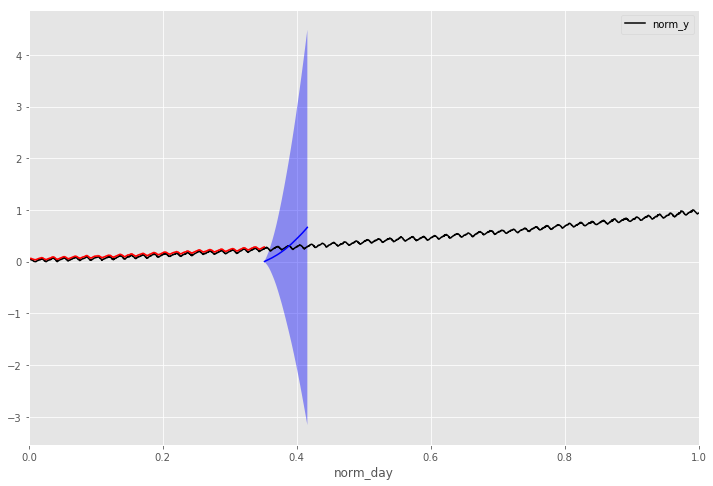

In [17]:
def plot_samples(samples, future=200):
    delta_means = np.mean(samples['delta'], axis=0)
    delta_stds = np.std(samples['delta'], axis=0)
    noise = delta_stds + np.mean(samples['sigma_delta']) + np.mean(samples['sigma_mu'])
    y = [delta_means[0]]
    for d in delta_means[1:]:
        y.append(y[-1] + d)
        
    y = np.asarray(y)
        
    ax = mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8), color='black')
    ax.plot(train['norm_day'], y, color='red')
    ax.fill_between(train['norm_day'], y - 2 * noise, y + 2 * noise, alpha=0.4, 
                          facecolor='red')
    
    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    ax.plot(test['norm_day'][:future], y_future_means[:future], color='blue')
    ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
                    y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.4, facecolor='blue')
    
    plt.show()

plot_samples(samples)

In [13]:
samples['y_future'].shape

(1000, 416)

In [14]:
test.shape

(416, 5)

In [26]:
np.std(samples['y_future'], axis=0).shape

(416,)

In [30]:
np.std(samples['y_future'][:,-1])

6.0723059273803051

In [31]:
samples['y_future'][:,-1]

array([  7.94860145e-01,   5.00984030e+00,   5.65619175e+00,
         5.58491729e+00,   9.20900288e-01,  -5.15357053e+00,
         9.74934315e+00,   1.49879029e+00,   3.61864476e+00,
         4.45486681e+00,   3.68130168e-01,   4.09167833e+00,
         3.59032420e+00,  -4.91874173e+00,   1.67969199e+00,
         1.05573143e+00,   1.21100063e+01,  -2.79374824e+00,
        -8.44219622e+00,   1.13401435e+00,   4.69835906e+00,
         7.73246828e-01,  -3.46912661e+00,  -2.94122799e+00,
        -5.49074167e+00,   5.92975668e+00,   2.31819069e+00,
         2.54963667e+00,   2.15363893e+00,  -7.20889855e+00,
         4.68640802e+00,   9.72499146e-01,  -9.20102189e+00,
         1.01600697e+01,   6.45925746e+00,   5.30407234e+00,
        -2.67956776e+00,  -1.38351831e+00,   4.59404576e+00,
         3.63611019e+00,   3.11696559e+00,   7.64722338e+00,
         5.16587763e+00,   1.02890099e+01,  -6.69856580e+00,
        -4.69194410e+00,   1.59290672e+00,   1.70274610e+00,
        -3.63598691e+00,